In [1]:
# импортируем библиотеки

import torch
import random
import numpy as np
import torchvision
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import dill
from IPython.display import clear_output

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

/tmp/ipykernel_6011/3520758902.py:7: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
from torchvision import datasets

In [3]:
download_dir = "../datasets/cifar"

# Скачиваем обучающую выборку.
#train_data = datasets.CIFAR10(root=download_dir, download=True, train=True)
train_data = datasets.CIFAR10(root=download_dir, download=True, train=True)

# Скачиваем валидационную выборку.
val_data = datasets.CIFAR10(root=download_dir, download=True, train=False)

In [4]:
# azot
print(type(train_data.data), train_data.data.shape)

<class 'numpy.ndarray'> (50000, 32, 32, 3)


In [5]:
# Объекты данных из обучающей выборки (50 000 цветных картинок размера 32 x 32).
x_train = torch.tensor(train_data.data)
print(x_train.shape, x_train.min(), x_train.max(), x_train.dtype, sep="\n")

torch.Size([50000, 32, 32, 3])
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
torch.uint8


In [6]:
# Предсказываемые величины для обучающей выборки (50 000 чисел от 0 до 9).
y_train = torch.tensor(train_data.targets)

print(y_train.shape, y_train.min(), y_train.max(), sep="\n")

torch.Size([50000])
tensor(0)
tensor(9)


In [7]:
# Сопоставление численных значений
#  (индексов в списке classes) реальным классам.
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
# Названия классов на русском языке.
classes_ru = [
    "самолёт",
    "машина",
    "птица",
    "кошка",
    "олень",
    "собака",
    "лягушка",
    "лошадь",
    "корабль",
    "грузовик",
]

In [9]:
# Аналогично записываем x и y для валидационной выборки (10 000 примеров).
x_val = torch.tensor(val_data.data)
y_val = torch.tensor(val_data.targets)

print(x_val.shape, y_val.shape, sep="\n")

torch.Size([10000, 32, 32, 3])
torch.Size([10000])


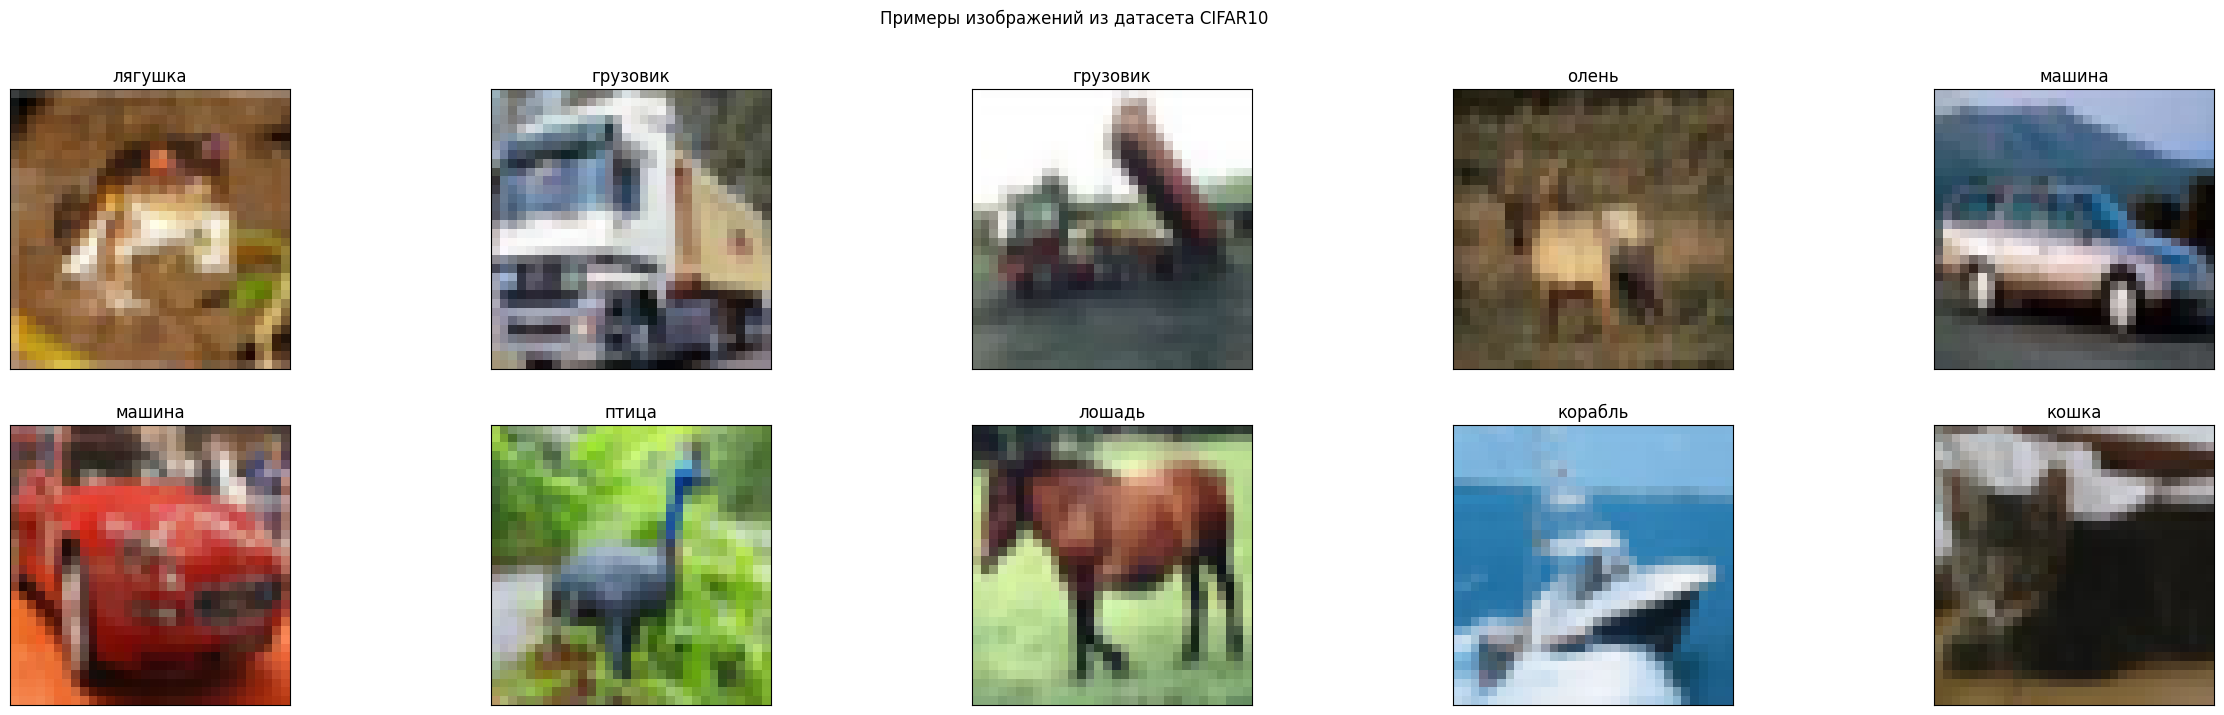

In [10]:
# Посмотрим на то, как выглядят картинки из датасета.

import matplotlib.pyplot as plt
%matplotlib inline

hh = 2
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(30, 4 * hh))
fig.suptitle("Примеры изображений из датасета CIFAR10")

for i, (x, y) in enumerate(zip(x_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    plt.title(classes_ru[y])
plt.show()

In [11]:
# При обучении нейросетей нам будет удобнее работать
#  с пикселями, представленными в виде вещественных чисел.
x_train = torch.tensor(train_data.data) / 255.
x_val = torch.tensor(val_data.data) / 255.

print(x_train.min(), x_train.max(), x_train.dtype, sep="\n")

tensor(0.)
tensor(1.)
torch.float32


$$H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \times \text{padding} - \text{dilation} \times (\text{kernel\_size} - 1) - 1}{\text{stride}} + 1 \right\rfloor$$

azot:  
residual connection - он должен прокидывать элементы карты на входе без пробразований  
потом карты складываются, чтобы сложить не только количество каналов должно совпадать, но размер основной карты и residual карты.
это значит, если в основная карта меняет размер, то и размер residual карты должен изменится. Обозначим $k', p', s', d'$ параметры свёртки для residual connection.
$$k' = 1$$
$$d' = 1$$
Нужно прокинуть значения карты на входе. Чтоб не прокидывать нули
$$p' = 0$$
получаем уравнение для определения $s'$ (stride)
$$H_{\text{out}} - 1 = \left\lfloor \frac{H_{\text{in}} - 1}{s'} \right\rfloor$$
учтём это в class ResidualBlock

In [3]:
None == None

True

In [12]:
# Свёртка.
conv_layer = torch.nn.Conv2d(
    in_channels=3,         # Число каналов на входе.
    out_channels=10,       # Число каналов на выходе.
    kernel_size=3,         # Размер ядра.
    padding=1,             # Размер паддинга (1 элемент добавляется с каждой стороны).
    padding_mode="zeros",  # Указываем, что в паддинге проставляем нули вдоль границ входного тензора.
    stride=1,              # Stride - 1 (смотрим на каждую позицию).
    dilation=1,            # Dilation - 1 (ядро прикладывается к фрагменту изображения без пропусков).
)

# Применяется слой свёртки к группе картинок в формате bs x c x h x w.
x = torch.rand(2, 3, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x = conv_layer(x)

print(f"Размер после свёртки: {x.shape}")

# azot
# (32 + 2*1 - 3)/1 + 1 = 32

Размер до свёртки: torch.Size([2, 3, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])


In [13]:
# Residual connection.
conv_layer_2 = torch.nn.Conv2d(
    in_channels=10,
    out_channels=10,
    kernel_size=3,
    padding=1,
)

x = torch.rand(2, 10, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x2 = conv_layer_2(x)

print(f"Размер после свёртки: {x2.shape}")

h = x + x2

Размер до свёртки: torch.Size([2, 10, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])


In [14]:
# Residual connection в ситуации, когда вход и выход
#  имеют разные количества каналов.
x = torch.rand(2, 3, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x2 = conv_layer(x)

print(f"Размер после свёртки: {x2.shape}")

# Вариант 1: объединяем (конкатенируем) тензоры вдоль размерности каналов.
h = torch.cat([x, x2], dim=1)

print(f"Размер выхода при конкатенации: {h.shape}")


# Вариант 2: применяем свёртку с ядром 1x1, чтобы привести
#  исходный тензор к состоянию, когда число каналов
#  в нём совпадает с числом каналов в выходном тензоре.
conv_1_1 = torch.nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=1,  # Ищем шаблоны размера 1x1xc
)
h = conv_1_1(x) + x2

print(f"Размер выхода при сумме через 1x1 свёртку: {h.shape}")

Размер до свёртки: torch.Size([2, 3, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])
Размер выхода при конкатенации: torch.Size([2, 13, 32, 32])
Размер выхода при сумме через 1x1 свёртку: torch.Size([2, 10, 32, 32])


In [ ]:
# Напишем свой блок свёртки с residual connection.

class ResidualBlock(torch.nn.Module):
    # Инициализация блока.
    def __init__(
        self,
        input_c,                   # Число каналов на входе.
        output_c,                  # Число каналов на выходе.
        kernel_size,               # Размер ядра.
        padding_size=None,         # если padding не указан, он подбирается так, 
                                   # чтоб не изменился размер карты   
        stride=1,
        input_h=None,              # Размер карты на входе.
        output_h=None,             # Размер карты на выходе.
        activation=torch.nn.ReLU,  # Класс функции активации.
    ):
        super().__init__()

        # Функция активации для нелинейности.
        # azot: скобочки важны. сначала создаём экземпляр класса 
        # а ниже вызовем его __call__
        self.activation = activation()

        # azot 
        self.batch_norm = torch.nn.BatchNorm2d(output_c)

        # TODO:
        # Паддинг подбираем такой, чтобы размеры h и w не менялись
        #  (считаем, что размер ядра всегда нечётный).
        if padding_size is None:
            assert stride == 1
            padding_size = (kernel_size-1)//2

        # TODO:
        # Операция свёртки.
        # Создайте сверточный слой с помощью класса torch.nn.Conv2d
        # укажите количество каналов на входе и выходе, размер ядра,
        # размер паддинга и режим его выполнения (заполнение нулями)
        self.conv0 = torch.nn.Conv2d(
            in_channels=input_c,
            out_channels=output_c,
            kernel_size=kernel_size,
            padding=padding_size,
            padding_mode='zeros',
            stride=stride,
        )

        # azot в оригинальной статье было две свёртки 
        # и через них уже пробрасывался skip connection
        # добавлю в блоке второй conv слой
        # пробовал так функция потерь не убывает
        # вернулся к варианту, который изначально был в  блокноте
        '''
        self.conv1 = torch.nn.Conv2d(
            in_channels=output_c,
            out_channels=output_c,
            kernel_size=kernel_size,
            padding=padding_size,
            padding_mode='zeros',
        )
        '''
        # Если числа каналов у входа и выхода различаются,
        if input_c != output_c or input_h !=  output_h:
            # ТОDO:
            # то будем делать свёртку с ядром размера 1.

            stride_correct = (input_h-1)//(output_h-1)
            assert (input_h-1)//stride_correct + 1 == output_h

            self.correct_channels = torch.nn.Conv2d(
                in_channels=input_c,
                out_channels=output_c,
                kernel_size=1,
                stride=stride_correct,
            )
        else:
            self.correct_channels = torch.nn.Identity()  # Слой, никак не меняющий вход.

    # Прямой проход.
    def forward(self, x):
        # ТОDO:
        # реализуйте прямой проход

        f_x = self.conv0(x)
        #f_x = self.activation(f_x)
        #f_x = self.conv1(f_x)
        h = f_x + self.correct_channels(x)

        # в задании 2 было полезно добавить нормализацию
        # повторил и здесь
        # без batch_norm los = 1.8 .. 1.9
        # c batch_norm los = 1.3 .. 1.4
        h = self.batch_norm(h)

        return self.activation(h)

In [16]:
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 3 канала на входе, 10 каналов на выходе,
# размер ядра свертки равен 3 и
# в качестве функции активации используется ReLU
residB1 = ResidualBlock(input_c=3,output_c=10,kernel_size=3)
residB1


ResidualBlock(
  (activation): ReLU()
  (batch_norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (correct_channels): Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1))
)

In [17]:
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 10 каналов на входе, 10 каналов на выходе и
# размер ядра свертки равен 3 и
# в качестве функции активации используется "Гиперболический тангенс"
residB2 = ResidualBlock(input_c=10,output_c=10,kernel_size=3,activation=torch.nn.Tanh)
residB2


ResidualBlock(
  (activation): Tanh()
  (batch_norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (correct_channels): Identity()
)

In [18]:
# Соберём вручную простую свёрточную нейросеть,
#  используя написанный ранее residual block.
from collections import OrderedDict

conv_layers = [
    (
        "residual_block_1",
        # TODO:
        # Создайте экземпляр класса ResidualBlock() у которого 3 канала на входе, 8 каналов на выходе,
        # размер ядра свертки равен 3 и
        # в качестве функции активации используется ReLU
        ResidualBlock(input_c=3,output_c=8,kernel_size=3),
    ),
    (
        "residual_block_2",
        # TODO:
        # Создайте экземпляр класса ResidualBlock() у которого 8 каналов на входе, 16 каналов на выходе,
        # размер ядра свертки равен 3 и
        # в качестве функции активации используется ReLU
        ResidualBlock(input_c=8,output_c=16,kernel_size=3),       
    ),
    (
        "pooling",
        # azot pooling уменьшает H,W в два раза (kernel_size=2)
        # (pooling - ядро двигается со stride=kernel_size)
        torch.nn.MaxPool2d(kernel_size=2),
    ),
    (
        "residual_block_3",
        # TODO:
        # Создайте экземпляр класса ResidualBlock() у которого 16 каналов на входе, 32 канала на выходе,
        # размер ядра свертки равен 3 и
        # в качестве функции активации используется ReLU
        ResidualBlock(input_c=16,output_c=32,kernel_size=3),
    ),
]

conv_model = torch.nn.Sequential(OrderedDict(conv_layers))
conv_model

Sequential(
  (residual_block_1): ResidualBlock(
    (activation): ReLU()
    (batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
  )
  (residual_block_2): ResidualBlock(
    (activation): ReLU()
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (residual_block_3): ResidualBlock(
    (activation): ReLU()
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(16,

In [19]:
# С помощью функции max в torch можно сделать MaxPooling.
# azot max(dim=1)
# свёртка по оси 1 (по колонкам)
h = torch.rand(2, 3)

print(h, h.max(1), h.max(1).values.shape, h[0, :], h[1, :], sep="\n\n")

tensor([[0.3853, 0.3657, 0.1688],
        [0.7732, 0.1311, 0.7766]])

torch.return_types.max(
values=tensor([0.3853, 0.7766]),
indices=tensor([0, 2]))

torch.Size([2])

tensor([0.3853, 0.3657, 0.1688])

tensor([0.7732, 0.1311, 0.7766])


In [20]:
# Теперь соберём вручную классификатор.
lin_layers = [
    (
        "linear_1",
        # TODO:
        # Сделайте полносвязный слой у которого 32 канала на входе, 16 каналов на выходе,
        # создайте для этого экземпляр класса torch.nn.Linear
        torch.nn.Linear(in_features=32, out_features=16)
    ),
    (
        "linear_activation_1",
        # TODO:
        # в качестве функции активации используется ReLU
        torch.nn.ReLU()        
    ),
    (
        "linear_2",
        # TODO:
        # Сделайте полносвязный слой у которого 16 каналов на входе, 10 каналов на выходе,
        # создайте для этого экземпляр класса torch.nn.Linear
        torch.nn.Linear(in_features=16, out_features=10)
    ),
    (
        "softmax",
        # azot: dim=-1 - это значит нормирование (в сумме вероятности дают 1) по последней размерности
        torch.nn.Softmax(-1),
    ),
]

lin_model = torch.nn.Sequential(OrderedDict(lin_layers))
lin_model

Sequential(
  (linear_1): Linear(in_features=32, out_features=16, bias=True)
  (linear_activation_1): ReLU()
  (linear_2): Linear(in_features=16, out_features=10, bias=True)
  (softmax): Softmax(dim=-1)
)

In [21]:
# Посмотрим на примере.
x = torch.rand(2, 3, 32, 32)

print(f"Изначальный размер: {x.shape}")

# Применяем свёрточные слои.
x = conv_model(x)

print(f"После свёрток: {x.shape}")

# Сделаем операцию GlobalMaxPooling.
x = x.max(-1).values.max(-1).values

print(f"После глобального пулинга: {x.shape}")

# Применяем классификатор.
x = lin_model(x)

# azot после классификатора каждый объект имеет на выходе вектор размером 10
# 10 - по количеству цифр
# выход рассматриваем как вероятность, что объект принадлежит классу
print(f"После классификатора: {x.shape}\n")

print(x, x.sum(1), sep="\n\n")

Изначальный размер: torch.Size([2, 3, 32, 32])
После свёрток: torch.Size([2, 32, 16, 16])
После глобального пулинга: torch.Size([2, 32])
После классификатора: torch.Size([2, 10])

tensor([[0.0301, 0.0916, 0.2544, 0.0186, 0.1013, 0.2172, 0.0063, 0.1900, 0.0277,
         0.0629],
        [0.0263, 0.0801, 0.2217, 0.0195, 0.0845, 0.2342, 0.0080, 0.2244, 0.0313,
         0.0701]], grad_fn=<SoftmaxBackward0>)

tensor([1.0000, 1.0000], grad_fn=<SumBackward1>)


In [22]:
# Повторим задание свёрточной нейронной сети на основе residual block,
# но в более общем виде при помощи обёртки torch.nn.Module.
IMG_SIZE = 32

class ResidualModel(torch.nn.Module):
    def __init__(
        self,
        out_size,                    # Число классов.
        residual_sizes,              # Задаём список троек: количество residual-блоков,
                                     #  число каналов и размер ядра в каждом таком блоке
        linear_sizes,                # Список размеров линейных слоёв в финальном классификаторе.
        activation = torch.nn.ReLU,  # Какую функцию активации использовать.
        flatten = True,              # Использовать Flatten или GlobalPooling.
    ):
        super().__init__()
        self.flatten = flatten

        # Собираем все свёрточные слои в один блок.
        conv_layers = []

        current_c = 3
        for group_index, (num_residual, out_channels, kernel_size) in enumerate(residual_sizes):
            for residual_index in range(num_residual):
                conv_layers.append((
                    # Добавляем несколько residual-блоков для каждой группы.
                    f"residual_{group_index}_{residual_index}",
                    ResidualBlock(
                        input_c = current_c if residual_index == 0 else out_channels,
                        output_c = out_channels,
                        kernel_size = kernel_size,
                        activation = activation,
                    ),
                ))
            current_c = out_channels
            if group_index < len(residual_sizes) - 1:
                conv_layers.append((
                    # В конце группы добавляем один pooling-слой,
                    # если это не последняя группа.
                    f"pooling_{group_index}",
                    torch.nn.AvgPool2d(2),
                ))

        self.conv_part = torch.nn.Sequential(OrderedDict(conv_layers))

        # Собираем все линейные слои во второй блок.
        # azot кол-во каналов на выходе последнего residual-блоков
        out_c = residual_sizes[-1][1]
        # azot h - после каждого блока (кроме последнего) residual стоит AvgPool2D с ядром 2
        final_size = IMG_SIZE // 2 ** (len(residual_sizes) - 1)
        clf_in_size = (out_c * final_size**2) if flatten else out_c

        linear_sizes = [clf_in_size, *linear_sizes, out_size]

        clf_layers = []

        for i, (from_size, to_size) in enumerate(zip(linear_sizes[:-1], linear_sizes[1:])):
            clf_layers.append((f"linear_{i}", torch.nn.Linear(from_size, to_size)))
            if i < len(linear_sizes) - 2:
                clf_layers.append((f"act_{i}", activation()))

                # azot в задании 2 применял dropout
                # пробовал повторять и здесь
                # los 1.3 .. 1.4 => 1.6 .. 1.7
                # уберу
                # clf_layers.append((f"dropout_{i}", torch.nn.Dropout()))

            else:
                clf_layers.append(("log_softmax", torch.nn.LogSoftmax(-1)))

        self.clf_part = torch.nn.Sequential(OrderedDict(clf_layers))

    def forward(self, x):  # input (bs x h x w x c_in)
        # azot permute - returns a view of the original tensor 
        # with its dimensions rearranged according to a specified order
        x = x.permute((0, 3, 1, 2))  # (bs x c_in x h x w)

        x = self.conv_part(x)  # bs x c_out x h' x w'

        if self.flatten:
            # Операция Flatten.
            # azot Flatten - One dimension can be indicated as -1, 
            # and PyTorch will automatically infer its size based 
            # on the total number of elements and the other specified dimensions
            # после flatten получаем тензор размерности 2
            # превая размерность сохраняется - это кол-во объектов
            x = x.reshape(x.shape[0], -1)  # bs x (c_out * h' * w')
        else:
            # Операция GlobalMaxPooling.
            x = x.max(-1).values.max(-1).values  # bs x c_out


        x = self.clf_part(x)  # bs x 10

        return x




In [23]:
def print_num_params(model):
    # Считаем общее количество обучаемых весов в модели.
    sum_params_size = 0
    for name, param in model.named_parameters():
        param_size = param.numel()
        print("{:<46} ~ {:<14} ~ {}".format(name, str(list(param.shape)), param_size))
        sum_params_size += param_size
    print(f"Общее число параметров ~ {sum_params_size}")


In [24]:
model = ResidualModel(
    out_size=10,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3), (2, 32, 3)],
    linear_sizes=[32],
    activation=torch.nn.ReLU,
    flatten=True,
)

model

ResidualModel(
  (conv_part): Sequential(
    (residual_0_0): ResidualBlock(
      (activation): ReLU()
      (batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_0_1): ResidualBlock(
      (activation): ReLU()
      (batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_1_0): ResidualBlock(
      (activation): ReLU()
      (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(8, 16, kernel_siz

In [25]:
print_num_params(model)

conv_part.residual_0_0.batch_norm.weight       ~ [8]            ~ 8
conv_part.residual_0_0.batch_norm.bias         ~ [8]            ~ 8
conv_part.residual_0_0.conv0.weight            ~ [8, 3, 3, 3]   ~ 216
conv_part.residual_0_0.conv0.bias              ~ [8]            ~ 8
conv_part.residual_0_0.correct_channels.weight ~ [8, 3, 1, 1]   ~ 24
conv_part.residual_0_0.correct_channels.bias   ~ [8]            ~ 8
conv_part.residual_0_1.batch_norm.weight       ~ [8]            ~ 8
conv_part.residual_0_1.batch_norm.bias         ~ [8]            ~ 8
conv_part.residual_0_1.conv0.weight            ~ [8, 8, 3, 3]   ~ 576
conv_part.residual_0_1.conv0.bias              ~ [8]            ~ 8
conv_part.residual_1_0.batch_norm.weight       ~ [16]           ~ 16
conv_part.residual_1_0.batch_norm.bias         ~ [16]           ~ 16
conv_part.residual_1_0.conv0.weight            ~ [16, 8, 3, 3]  ~ 1152
conv_part.residual_1_0.conv0.bias              ~ [16]           ~ 16
conv_part.residual_1_0.correct_channe

In [26]:
# TODO:
# Используя созданный ранее класс ResidualModel,
# создайте нейронную сеть с такой же архитектурой как и ранее,
# но использующую глобальный MaxPooling перед применением полносвязных слоев 

model = ResidualModel(
    out_size=10,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3), (2, 32, 3)],
    linear_sizes=[32],
    activation=torch.nn.ReLU,
    flatten=False,
)
model

ResidualModel(
  (conv_part): Sequential(
    (residual_0_0): ResidualBlock(
      (activation): ReLU()
      (batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_0_1): ResidualBlock(
      (activation): ReLU()
      (batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_1_0): ResidualBlock(
      (activation): ReLU()
      (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(8, 16, kernel_siz

In [27]:
# TODO:
# выведите подробную информацию о коичечестве параметров этой неросети 
print_num_params(model)

conv_part.residual_0_0.batch_norm.weight       ~ [8]            ~ 8
conv_part.residual_0_0.batch_norm.bias         ~ [8]            ~ 8
conv_part.residual_0_0.conv0.weight            ~ [8, 3, 3, 3]   ~ 216
conv_part.residual_0_0.conv0.bias              ~ [8]            ~ 8
conv_part.residual_0_0.correct_channels.weight ~ [8, 3, 1, 1]   ~ 24
conv_part.residual_0_0.correct_channels.bias   ~ [8]            ~ 8
conv_part.residual_0_1.batch_norm.weight       ~ [8]            ~ 8
conv_part.residual_0_1.batch_norm.bias         ~ [8]            ~ 8
conv_part.residual_0_1.conv0.weight            ~ [8, 8, 3, 3]   ~ 576
conv_part.residual_0_1.conv0.bias              ~ [8]            ~ 8
conv_part.residual_1_0.batch_norm.weight       ~ [16]           ~ 16
conv_part.residual_1_0.batch_norm.bias         ~ [16]           ~ 16
conv_part.residual_1_0.conv0.weight            ~ [16, 8, 3, 3]  ~ 1152
conv_part.residual_1_0.conv0.bias              ~ [16]           ~ 16
conv_part.residual_1_0.correct_channe

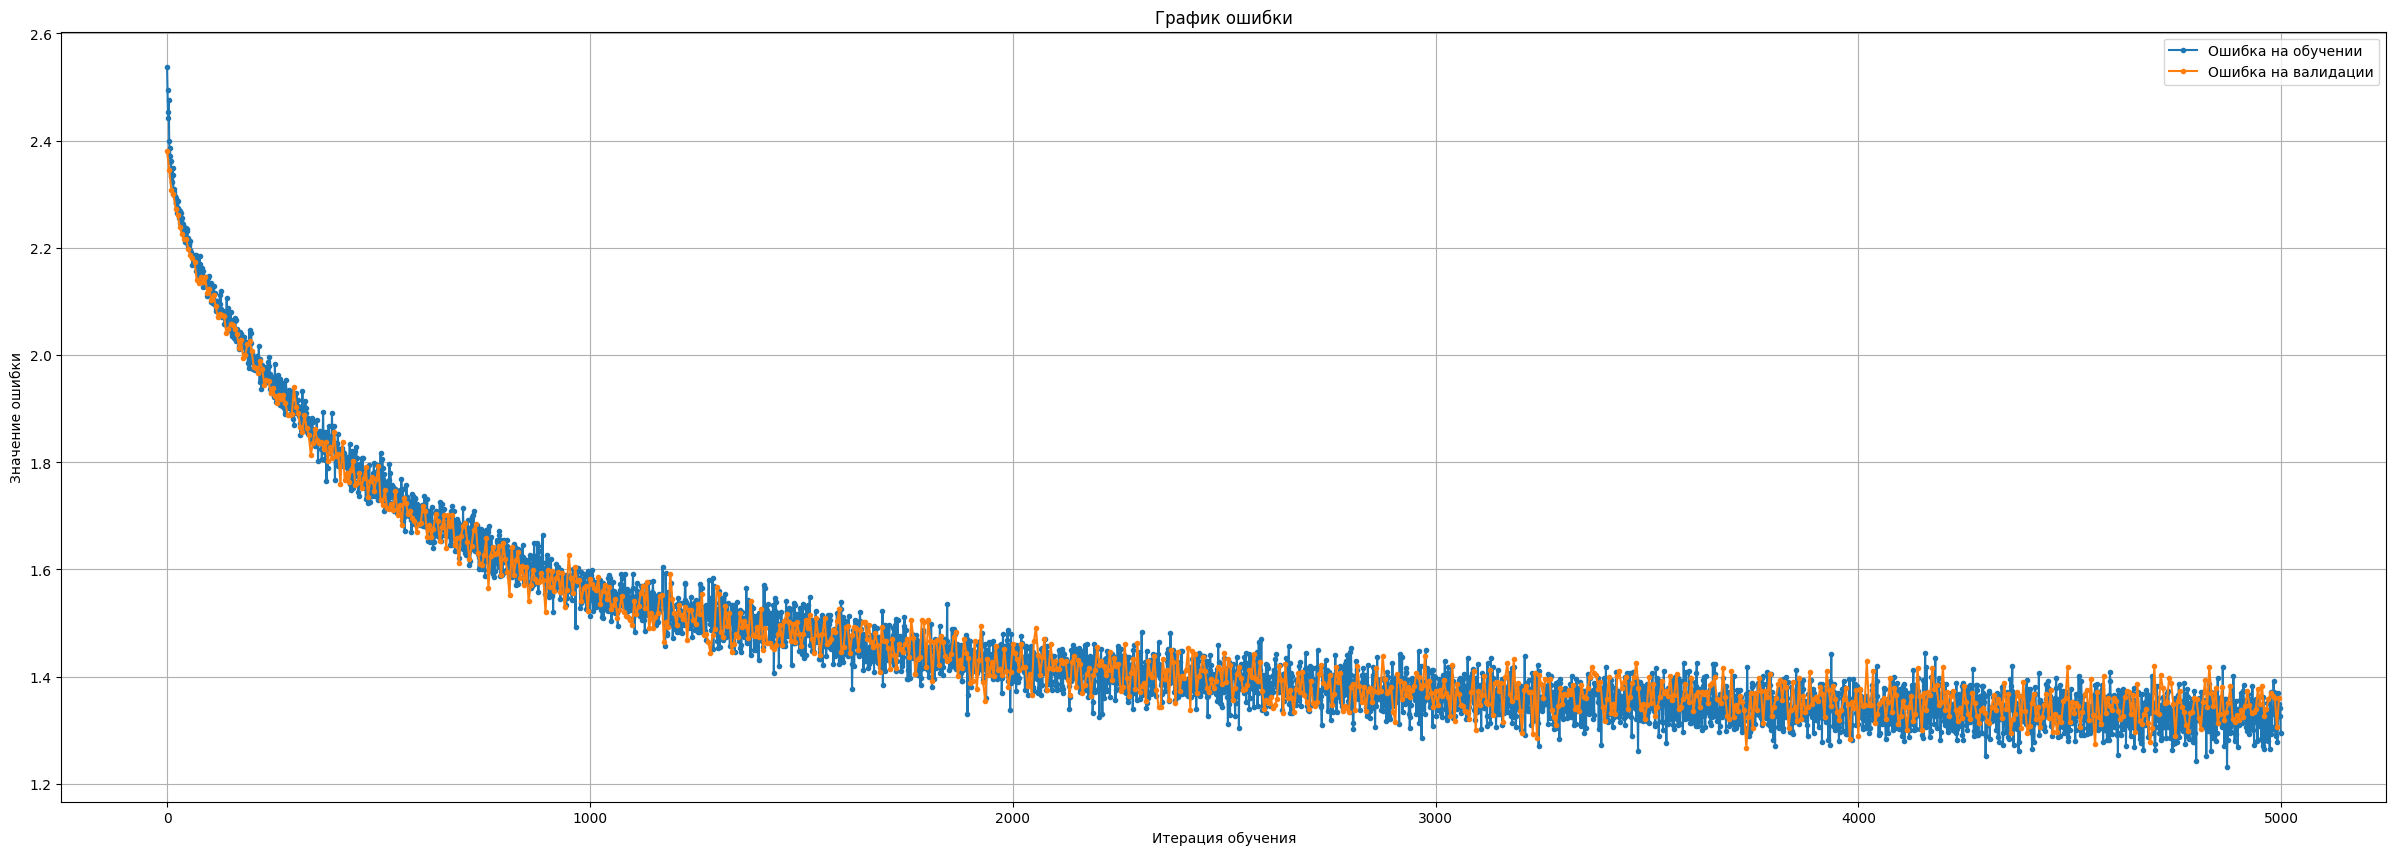

In [28]:
# Реализуем цикл обучения модели.
# ВАЖНО, что обучение модели с параметрами, приведёнными ниже, работает очень долго.

# Для ускорения обучения используем видеокарту компьютера
#  или виртуальной машины, если есть такая возможность.
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 5000
batch_size = 1000
val_every = 5

model = ResidualModel(
    out_size=10,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3)],
    linear_sizes=[32],
    activation=torch.nn.ReLU,
    flatten=False,
).to(dtype=x_train.dtype, device=device)  # Важно, чтобы все тензоры были одного типа и на одном устройстве.

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
)

# Шедулер (scheduler) отвечает за изменение величины шага градиентного спуска, который
#  в данном случае мы будем постепенно уменьшать с течением времени.
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

loss_fn = torch.nn.NLLLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()

    # Будем на каждой итерации обучения брать не все 50 000 картинок,
    #  а лишь случайные batch_size из них.
    batch_pos = torch.randint(high=x_train.shape[0], size=[batch_size])

    pred = model(x_train[batch_pos].to(device))  # Также переносим тензоры на устойство.
    loss = loss_fn(pred, y_train[batch_pos].to(device))

    loss.backward()
    optimizer.step()

    losses["train"].append(loss.item())

    # Каждые val_every итераций считаем значение loss на валидационной выборке.
    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch_pos = torch.randint(high=x_val.shape[0], size=[batch_size])
            val_pred = model(x_val[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_val[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())

    # Каждые 1000 итераций уменьшаем шаг градиентного спуска.
    if epoch % 1000 == 0:
        scheduler.step()

    # Каждые 100 итераций рисуем графики loss.
    if epoch % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

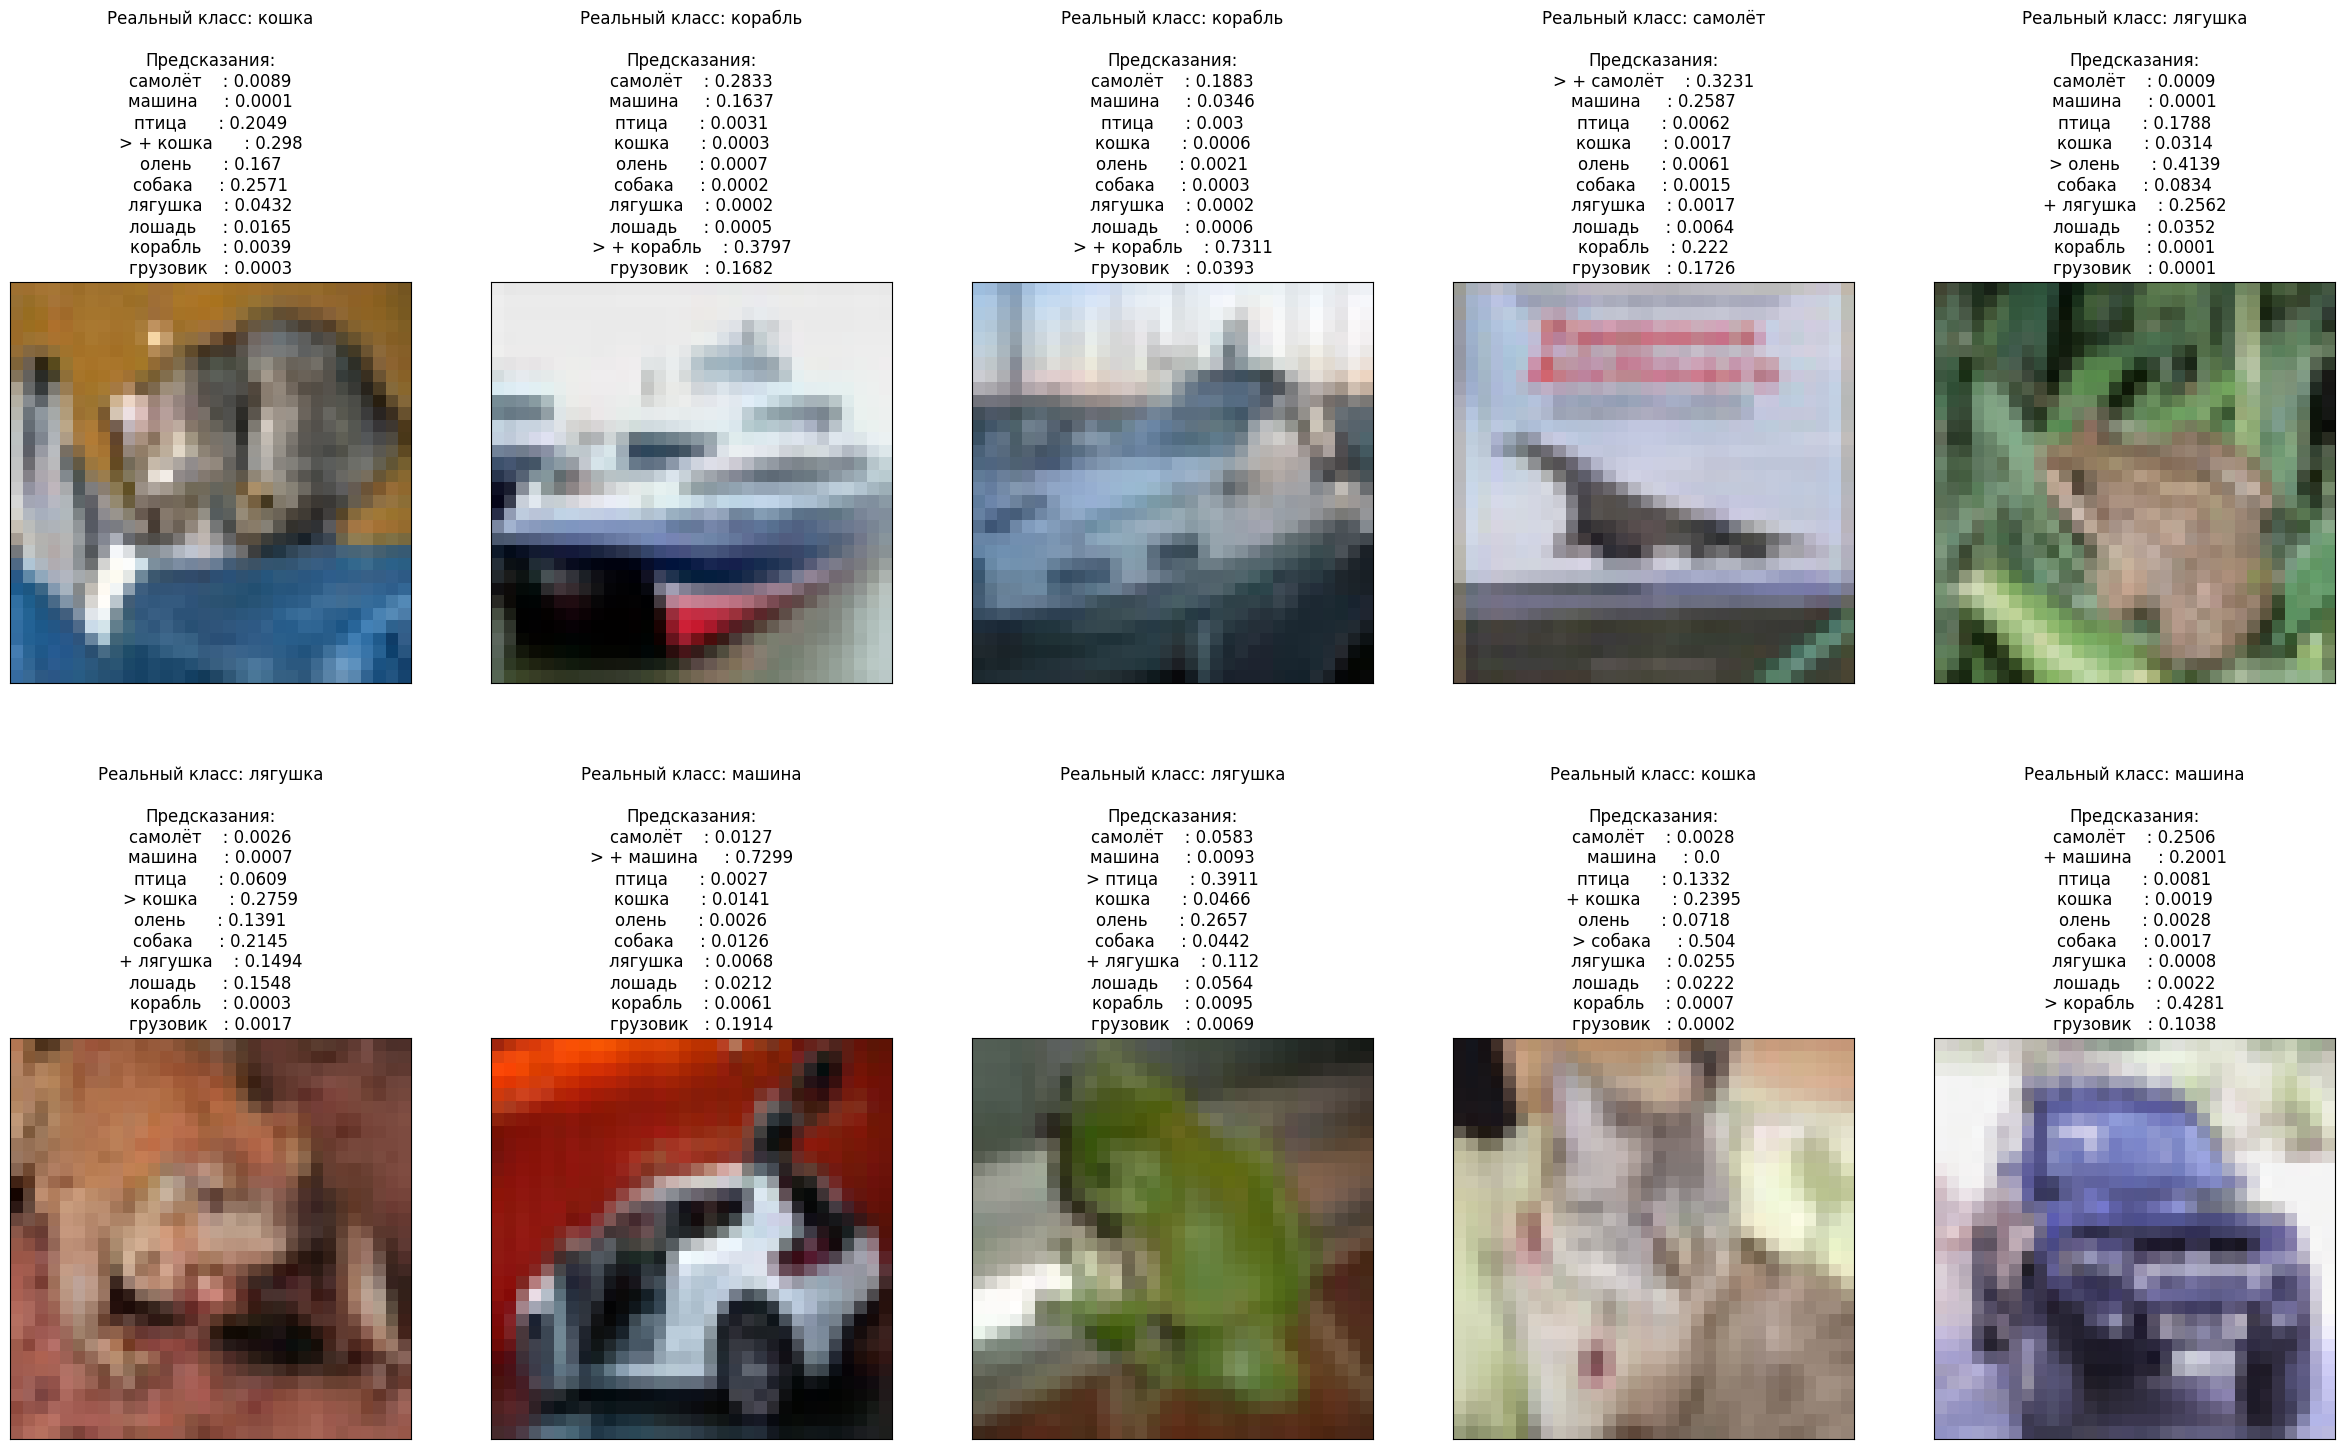

In [31]:
# Посмотрим на предсказания нашей модели на примерах из валидационной выборки.

classes_ru = [
    "самолёт",
    "машина",
    "птица",
    "кошка",
    "олень",
    "собака",
    "лягушка",
    "лошадь",
    "корабль",
    "грузовик",
]

def show_results(model, h=2, w=5):
    with torch.no_grad():
        batch_probs = model(x_val[:h*w].to(device)).exp()

        fig, ax = plt.subplots(h, w, figsize=(30, 9 * h))
        for i in range(h * w):
            plt.subplot(h, w, i+1)
            plt.imshow(x_val[i])
            title = f'Реальный класс: {classes_ru[y_val[i]]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[i] else "+ ",
                    classes_ru[j],
                    round(prob.item(), 4),
                )

            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

show_results(model)

#### Задание.
Примените технологию residual connection для нейросети из задания № 2. 

1) Опишите архитектуру нейросети

2) Создайте экземпляр класса ResidualModel

3) Проведите обучение нейронной сети. Сделайте отображение величины ошибки для тренировочной и валидационной выборки нак графике в процесе вычислений (аналогично примеру выше). 

4) Отобразите результат классификации с указанием класса-результата и верного ответа для 10 случайных картинок тестовой выборки (аналогично примеру выше).
5) Сравните точность полученной модели с той, что была реализована в задании № 2.
   

In [36]:
# ваш код здесь

### 1. Датасет для классификации изображений из задания 2 - Oxford-IIIT Pet Dataset. 

https://pytorch.org/vision/stable/datasets.html

Выбрал [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Это изображения кошек и собак. 37 классов - разные породы кошек и собак. Может использоваться для сегментации. Здесь буду использовать для бинарной классификации - кошка или собака

In [32]:
normalizer = torchvision.transforms.Normalize(
    mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
    )
# преобразование картинки в тензор и обратно
img2t = torchvision.transforms.ToTensor()
t2img = torchvision.transforms.ToPILImage()

In [33]:
# resize картинок к 307x307
# kernel = 11 stride =4
# (307-11)/4 делится на цело
IMG_SIZE = 307
resizer = torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE))

#сразу преобразуем к нужному размеру
transformer = torchvision.transforms.Compose(
                      [resizer,
                       torchvision.transforms.ToTensor(),
                       normalizer])

In [34]:
# есть возможность при загрузке разделить картинки на обучающую выборку и тест
pet_train = torchvision.datasets.OxfordIIITPet(
    '../datasets/', download=True, split='trainval',
    target_types='binary-category',transform=transformer
    )
pet_test = torchvision.datasets.OxfordIIITPet(
    '../datasets/', download=True, split='test',
    target_types='binary-category',transform=transformer
    )

In [35]:
#исходный датасет без трансформации
pet_test0 = torchvision.datasets.OxfordIIITPet(
    '../datasets/', download=True, split='test',
    target_types='binary-category'
    )

In [36]:
bin_classes = pet_train.bin_classes
# чтобы выравнять баланс по классам
# сгруппируем объекты по классам
cls_idx = {cls: [] for cls in bin_classes}

for i, obj in enumerate(pet_train):
    cls_lbl = bin_classes[obj[1]]
    cls_idx[cls_lbl].append(i)

(len(cls_idx['Cat']),len(cls_idx['Dog']))

(1188, 2492)

In [37]:
# например возьмём в обучение собак столько же сколько кошек
balanced_idx = cls_idx['Cat'].copy()
balanced_idx.extend(random.sample(cls_idx['Dog'],len(cls_idx['Cat'])))
#сначалла идут кошки затем ровно столько же собак
len(balanced_idx),pet_train[balanced_idx[0]][1],pet_train[balanced_idx[-1]][1]

(2376, 0, 1)

In [38]:
balanced_dataset = torch.utils.data.Subset(pet_train, balanced_idx)

### 1. Архитектура сети в задании 2 по мотивам alexNet
меняем свёртки на residual блоки


In [40]:
class AlexResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.features = torch.nn.Sequential(
            # (307 - 11) / 4 + 1
            # 307x307x3 -> 75x75x96
            ResidualBlock(input_c=3, output_c=96, kernel_size=11, padding_size=0, stride=4),
            # (75-3)/2+1
            # -> 37x37x96
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            # (37+2*2-5)/1+1 - здесь и дальше свёртки такие, что не меняют размер
            # -> 37x37x256
            ResidualBlock(96, 256, kernel_size=5, padding_size=2),
            # (37-3)/2+1
            # -> 18x18x256
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            # -> 18x18x384
            ResidualBlock(256, 384, kernel_size=3, padding_size=1),
            # -> 18x18x384
            ResidualBlock(384, 384, kernel_size=3, padding_size=1),
            # -> 18x18x256
            ResidualBlock(384, 256, kernel_size=3, padding_size=1),
            # (18-3)/3+1
            # -> 6x6x256
            torch.nn.MaxPool2d(kernel_size=3),
        )
        self.classifier = torch.nn.Sequential(
            # 6x6x256 -> 9216
            torch.nn.Linear(9216, 500),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(500, 200),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(200, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [41]:
arnet = AlexResNet()
arnet

AlexResNet(
  (features): Sequential(
    (0): ResidualBlock(
      (activation): ReLU()
      (batch_norm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
      (correct_channels): Conv2d(3, 96, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResidualBlock(
      (activation): ReLU()
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (correct_channels): Conv2d(96, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ResidualBlock(
      (activation): ReLU()
      (batch_norm): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0): Conv2d(256, 

In [ ]:
# кол-во параметров
print_num_params(arnet)

conv_part.residual_0_0.batch_norm.weight       ~ [8]            ~ 8
conv_part.residual_0_0.batch_norm.bias         ~ [8]            ~ 8
conv_part.residual_0_0.conv0.weight            ~ [8, 3, 3, 3]   ~ 216
conv_part.residual_0_0.conv0.bias              ~ [8]            ~ 8
conv_part.residual_0_0.correct_channels.weight ~ [8, 3, 1, 1]   ~ 24
conv_part.residual_0_0.correct_channels.bias   ~ [8]            ~ 8
conv_part.residual_0_1.batch_norm.weight       ~ [8]            ~ 8
conv_part.residual_0_1.batch_norm.bias         ~ [8]            ~ 8
conv_part.residual_0_1.conv0.weight            ~ [8, 8, 3, 3]   ~ 576
conv_part.residual_0_1.conv0.bias              ~ [8]            ~ 8
conv_part.residual_1_0.batch_norm.weight       ~ [16]           ~ 16
conv_part.residual_1_0.batch_norm.bias         ~ [16]           ~ 16
conv_part.residual_1_0.conv0.weight            ~ [16, 8, 3, 3]  ~ 1152
conv_part.residual_1_0.conv0.bias              ~ [16]           ~ 16
conv_part.residual_1_0.correct_channe

In [43]:
# определяем, где будем
# если есть граф процессор от Nvidia, то на нем. Если нет, то на cpu

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

# отправляем туда нашу нейронку
arnet = arnet.to(device)

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 200

# в качестве функции потерь будем использовать CrossEntropyLoss()
loss_fn = torch.nn.CrossEntropyLoss()
losses = {"train": [], "val": []}

accuracy = {"train": [], "val": []}

optimizer = torch.optim.SGD(
    arnet.parameters(),
    lr=1e-2,
)

# Шедулер (scheduler) отвечает за изменение величины шага градиентного спуска, который
#  в данном случае мы будем постепенно уменьшать с течением времени.
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)


In [45]:
# загрузчик батча для обуающей выборки
dataloader = torch.utils.data.DataLoader(
    balanced_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #прежде чем вернуть батч, его положат на устройство
    #? не понял как потом итерироваться по нему если он на куде
    #pin_memory=True,
    #pin_memory_device=device
)

# для тестовой выборки
testloader = torch.utils.data.DataLoader(pet_test, batch_size=BATCH_SIZE) #, drop_last=True)

In [ ]:
for epoch in range(1, NUM_EPOCHS + 1):

    # los = CrossEntropyLoss - аддитивна
    # пробежим по всем батчам - получим суммарный los
    los_epoch = 0
    # точность на train
    accuracy_epoch = 0
    total_sample = 0

    # на каждом шаге цикла получаем очередной батч из генератора
    for batch_images, batch_labels in dataloader:

        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        X_batch = batch_images.to(device)
        y_batch = batch_labels.to(device)

        # делаем предсказание
        preds = arnet.forward(X_batch)

        # считаем лосс значение
        loss_value = loss_fn(preds, y_batch)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

        los_epoch += loss_value.data.cpu()
        accuracy_epoch += (preds.argmax(dim=1) == y_batch).float().sum().data.cpu()
        total_sample += len(batch_images)

    losses["train"].append(los_epoch)
    accuracy["train"].append(accuracy_epoch)

    # потери на тесте
    los_epoch = 0
    # точность на тесте
    accuracy_epoch = 0
    total_sample = 0

    with torch.no_grad():
        for batch_images, batch_labels in testloader:
            X_batch = batch_images.to(device)
            y_batch = batch_labels.to(device)

            preds = arnet.forward(X_batch)
            loss_value = loss(preds, y_batch)

            los_epoch += loss_value.data.cpu()
            accuracy_epoch += (preds.argmax(dim=1) == y_batch).float().sum().data.cpu()
            total_sample += len(batch_images)

    losses["val"].append(los_epoch)
    accuracy["val"].append(accuracy_epoch)

    clear_output(True)
    fig, ax = plt.subplots(figsize=(30, 10))
    plt.title("График ошибки")
    plt.plot(losses["train"], ".-", label="Ошибка на обучении")
    plt.plot(losses["val"], ".-", label="Ошибка на валидации")
    plt.xlabel("Итерация обучения")
    plt.ylabel("Значение ошибки")
    plt.legend()
    plt.grid()
    plt.show()


<ipython-input-37-61e40d118354>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


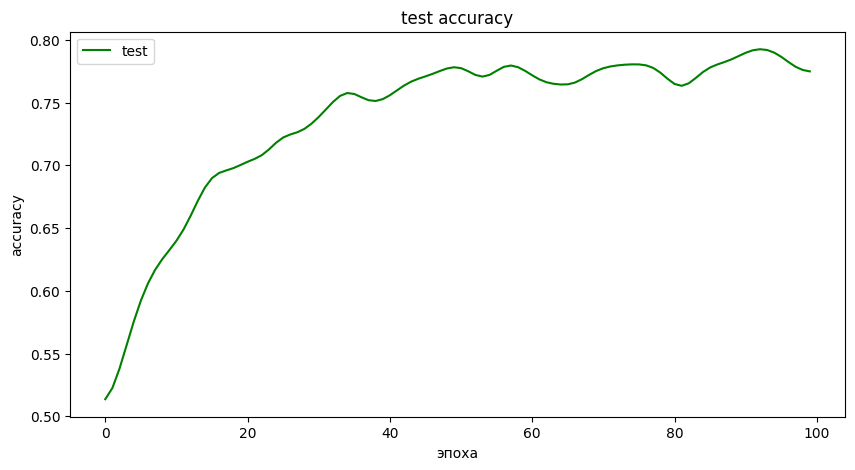

In [ ]:
# График изменения accuracy на тестовых данных

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'accuracy',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
ax.plot(accuracy['val'],  label='test')
ax.plot(accuracy['train'],  label='train')

ax.legend()
plt.show()


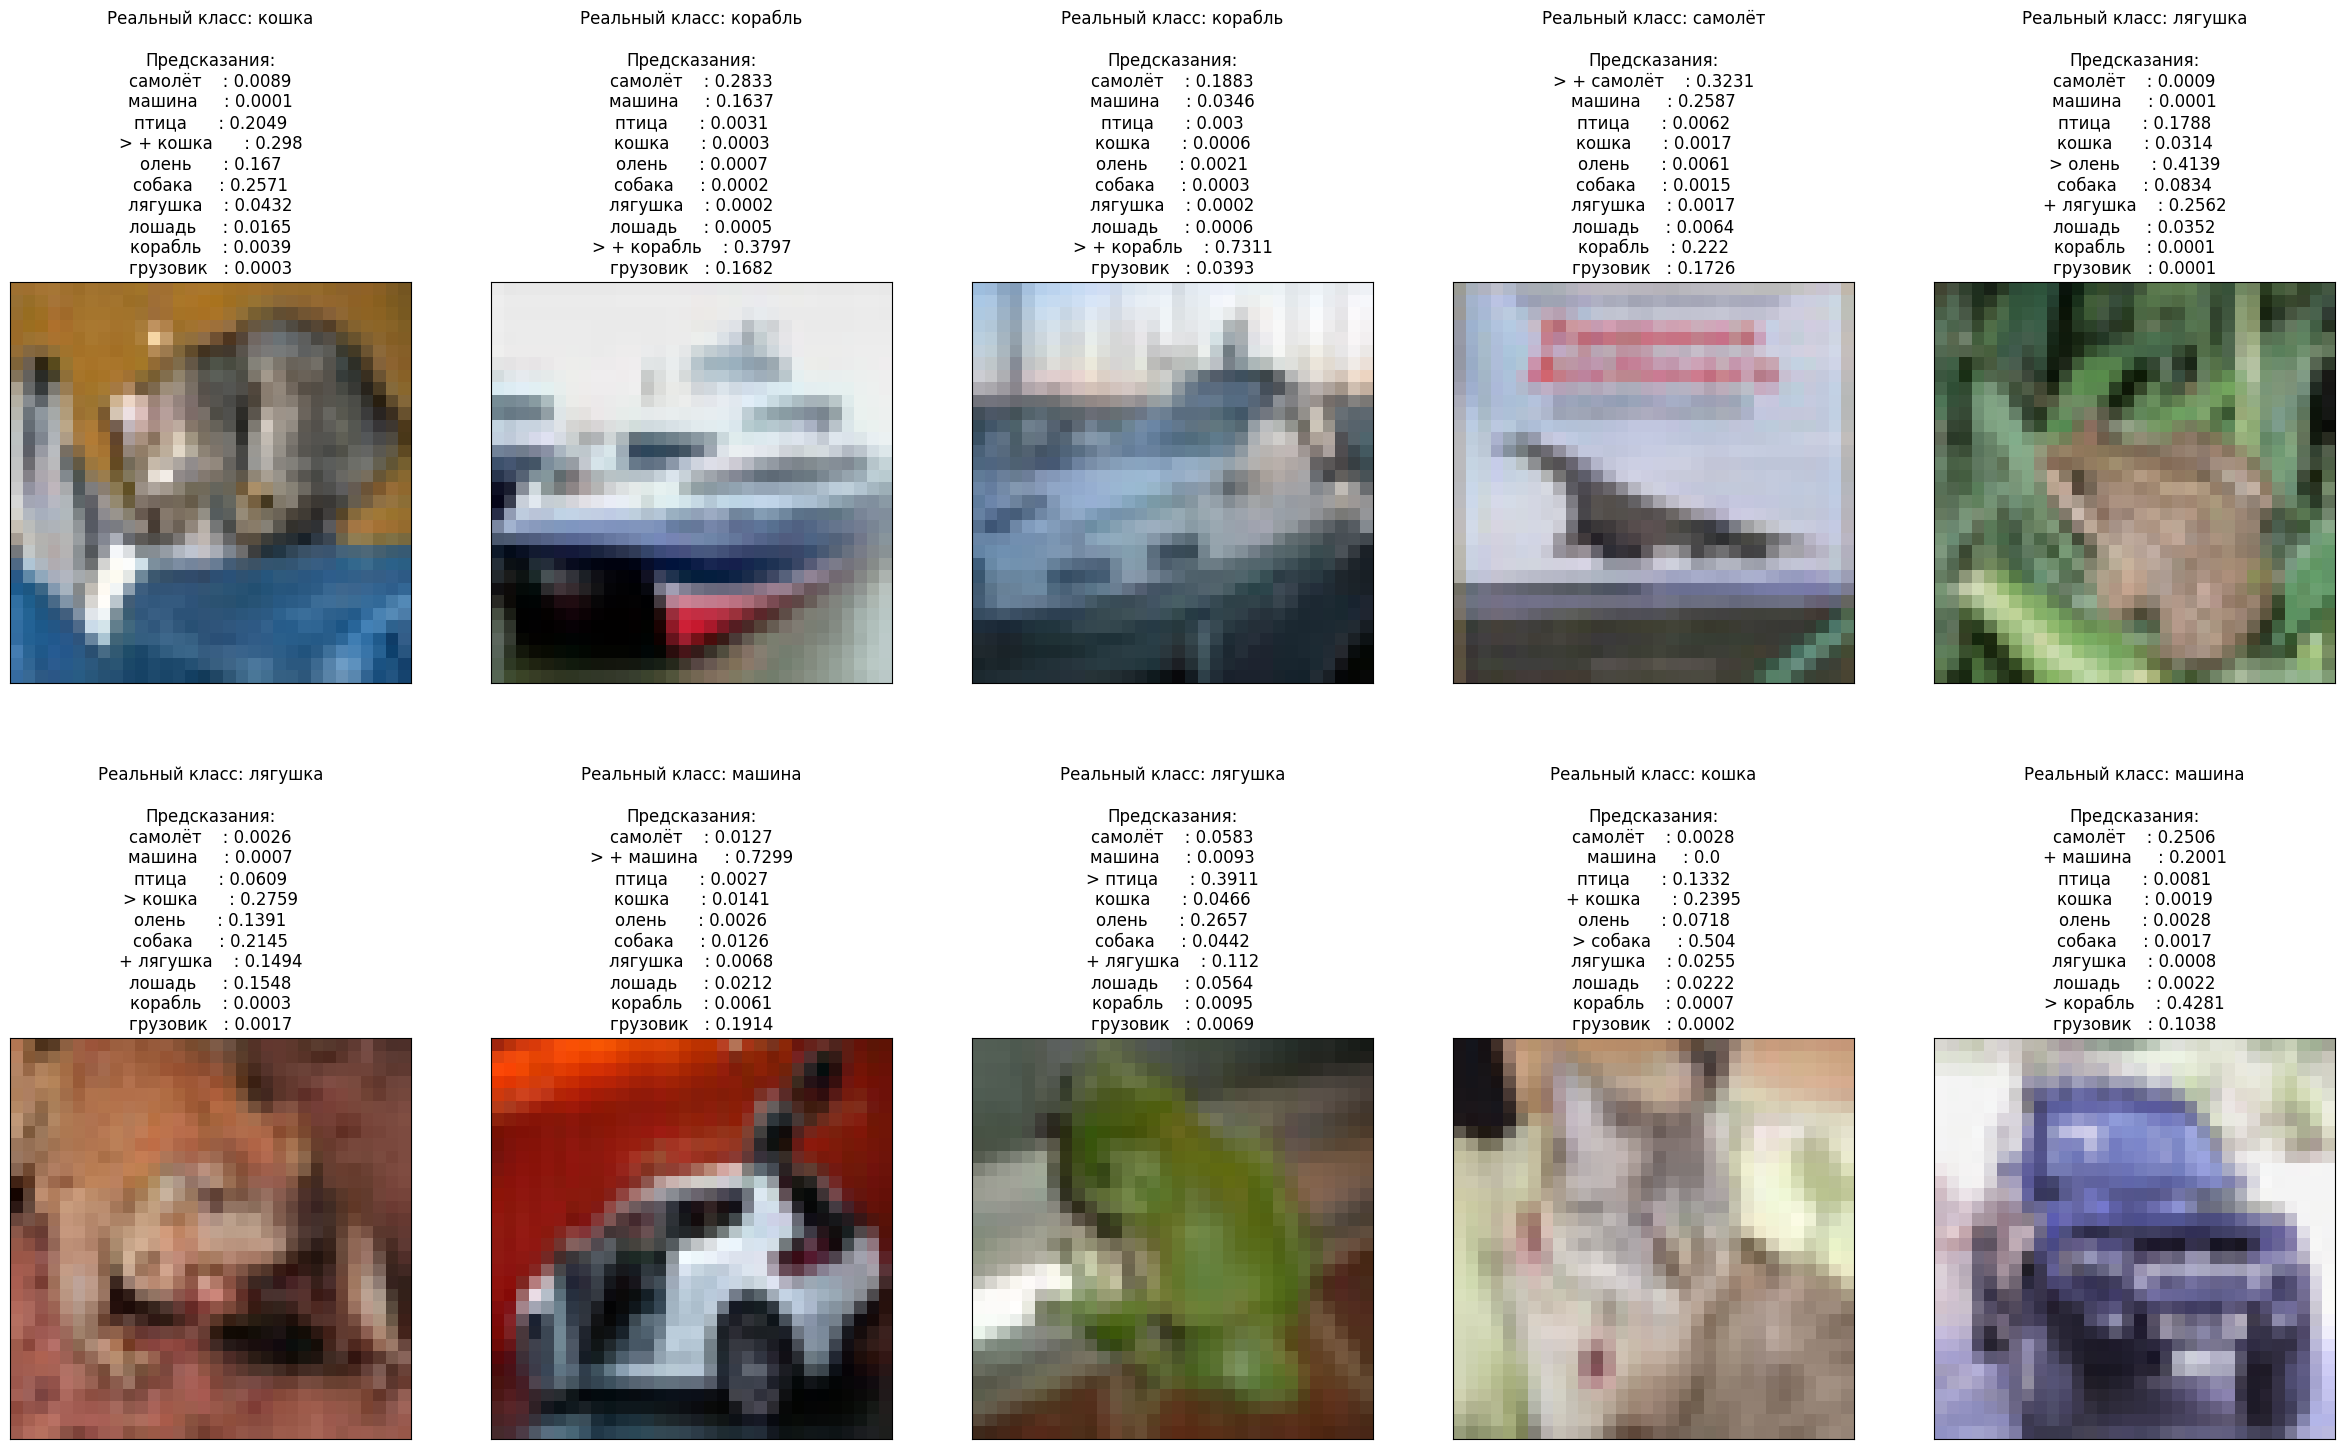

In [ ]:
# Посмотрим на предсказания нашей модели на примерах из валидационной выборки.

classes_ru = [
    "кошка",
    "собака",
]

def show_results(model, h=5, w=2):
    with torch.no_grad():
        for batch_images, batch_labels in testloader:
            X_batch = batch_images.to(device)
            y_batch = batch_labels.to(device)

            preds = model.forward(X_batch)

            fig, ax = plt.subplots(h, w, figsize=(30, 9 * h))
            for i in range(h * w):
                plt.subplot(h, w, i+1)
                plt.imshow(x_val[i])
                title = f'Реальный класс: {classes_ru[y_val[i]]}\n\nПредсказания:'
                y_pred = torch.argmax(batch_probs[i])
                for j, prob in enumerate(batch_probs[i]):
                    title += '\n{}{}{: <10} : {}'.format(
                        "" if j != y_pred else "> ",
                        "" if j != y_val[i] else "+ ",
                        classes_ru[j],
                        round(prob.item(), 4),
                    )

                plt.title(title)
                plt.xticks([])
                plt.yticks([])
            plt.show()
            break

show_results(arnet)